In [36]:
import cv2  
import easyocr  
import pytesseract 
from mediapipe import solutions 
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt
import mediapipe as mp

#image_path = "IMG_NAME_CHECK_5Digit.jpg"  
#image = cv2.imread(image_path) 
#image1 = cv2.imread(image_path) 


Text(0.5, 1.0, 'Aligned Image')

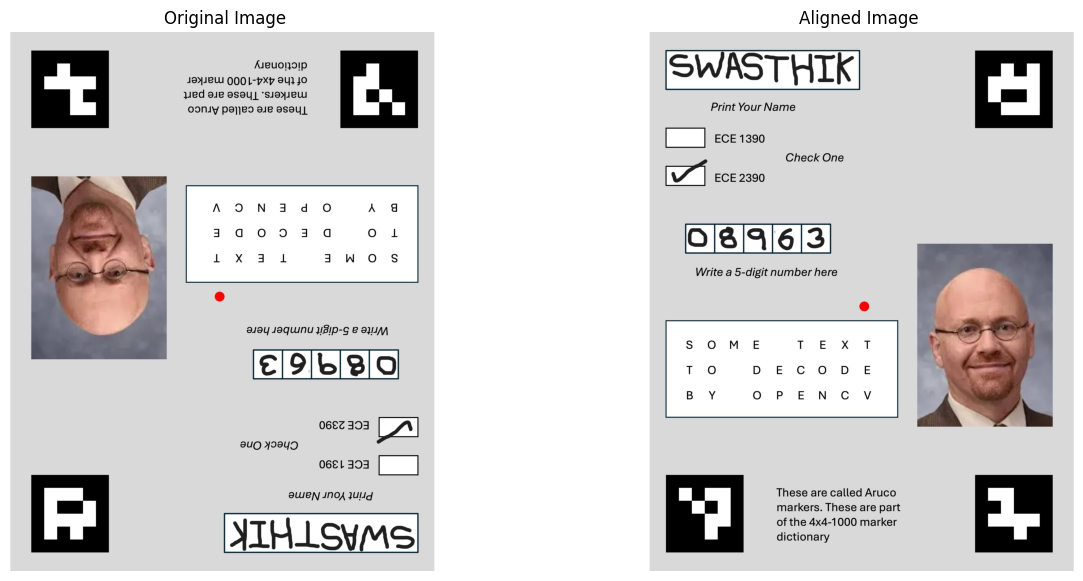

In [37]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

reader = easyocr.Reader(['en'])
image = cv2.imread('IMG_NAME_CHECK_5Digit_rotate.jpg')  
img_original = cv2.imread('Homework8.jpg')  
image1 = cv2.imread('IMG_NAME_CHECK_5Digit_rotate.jpg') 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)

aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_1000)
parameters = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)
corners, ids, _ = detector.detectMarkers(gray)
corners_original, ids_original, _ = detector.detectMarkers(gray_original)

if ids is None or ids_original is None:
    print("Error: Not enough ArUco markers detected.")
    exit()

if len(ids) < 3 or len(ids_original) < 3:
    print("Error: At least three markers are needed in both images.")
    exit()


matched_ids = []
src_pts = []
dst_pts = []

for marker_id in ids.flatten():
    if marker_id in ids_original.flatten():
        idx = np.where(ids.flatten() == marker_id)[0][0]
        idx_original = np.where(ids_original.flatten() == marker_id)[0][0]

        src_pts.append(corners[idx][0].mean(axis=0)) 
        dst_pts.append(corners_original[idx_original][0].mean(axis=0))
        matched_ids.append(marker_id)

if len(src_pts) < 3:
    print("Error: At least three matching ArUco markers are required.")
    exit()

src_pts = np.array(src_pts, dtype=np.float32)
dst_pts = np.array(dst_pts, dtype=np.float32)

matrix = cv2.getAffineTransform(src_pts[:3], dst_pts[:3])

aligned_image = cv2.warpAffine(image, matrix, (img_original.shape[1], img_original.shape[0]))

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].axis('off')
axes[0].set_title('Original Image')

axes[1].imshow(cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB))
axes[1].axis('off')
axes[1].set_title('Aligned Image')

In [38]:
dpi = 300
cm_to_pixels = lambda cm: int((cm / 2.54) * dpi)

def crop_region(image, x_cm, y_cm, w_cm, h_cm):
    x = cm_to_pixels(x_cm) + image.shape[1] // 2 
    y = cm_to_pixels(y_cm) + image.shape[0] // 2 
    w = cm_to_pixels(w_cm)
    h = cm_to_pixels(h_cm)
    return image[max(0, y):y+h, max(0, x):x+w]
reader = easyocr.Reader(['en'])

name_box = crop_region(aligned_image, -10, -15, 20, 3)
name_result = reader.readtext(name_box)
if name_result:
    detected_name = name_result[0][1] 
    print("Detected Name:", detected_name)
else:
    print("No name detected.")


Detected Name: SWASTHIK


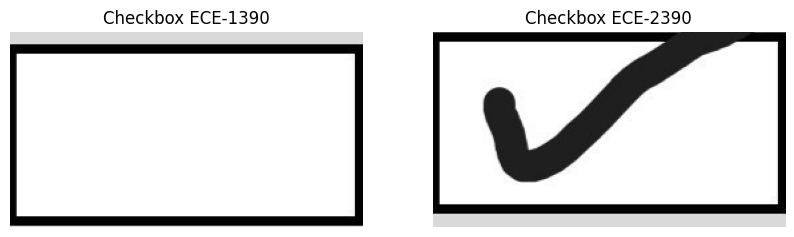

Checkbox 1390: False
Checkbox 2390: True


In [39]:
def is_checkbox_marked(checkbox):
    gray = cv2.cvtColor(checkbox, cv2.COLOR_BGR2GRAY)
    return np.mean(gray) <200  

checkbox_1390 = crop_region(aligned_image, -11, -10, 2.25, 1.25)
checkbox_2390 = crop_region(aligned_image, -11, -7.75,2.25,1.25)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(checkbox_1390)
plt.title('Checkbox ECE-1390')
plt.axis('off') 

plt.subplot(1, 2, 2) 
plt.imshow(checkbox_2390)
plt.title('Checkbox ECE-2390')
plt.axis('off')

plt.show()
is_1390_marked = is_checkbox_marked(checkbox_1390)
is_2390_marked = is_checkbox_marked(checkbox_2390)

print("Checkbox 1390:", is_1390_marked)
print("Checkbox 2390:", is_2390_marked)


[0, 8, 9, 6, 3]


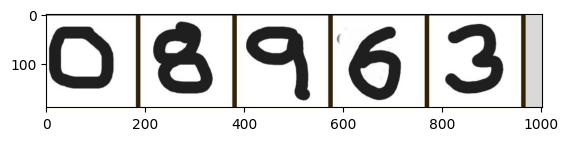

In [40]:
five_digits = crop_region(aligned_image, -9.8, -4.4, 8.5, 1.6) 
digit1 = crop_region(aligned_image, -9.8, -4.4, 1.5, 1.6)
digit2 = crop_region(aligned_image, -8.3, -4.4, 1.5, 1.6)
digit3 = crop_region(aligned_image, -6.6, -4.4, 1.5, 1.6)
digit4 = crop_region(aligned_image, -5, -4.4, 1.5, 1.6)
digit5 = crop_region(aligned_image, -3.3, -4.4, 1.5, 1.6)
plt.imshow(five_digits)
data = [ digit1,digit2,digit3,digit4,digit5]
digits = []
for i in range(1,6):
    result = reader.readtext(data[i-1])
    digits.append(int(result[0][1]))
print(digits)





Decoded Text: Ss O M E T E X T
T O D ECO D E
B Y O P EN C V



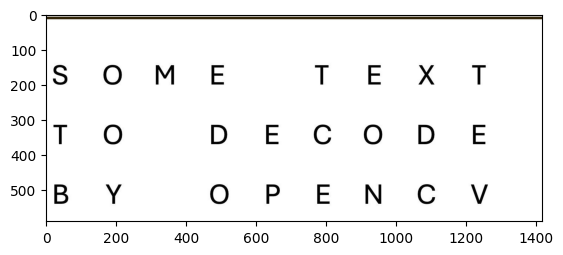

In [41]:
import pytesseract

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

text_box = crop_region(aligned_image, -10, 1, 12, 5)
plt.imshow(text_box)

tesseract_text = pytesseract.image_to_string(text_box, config="--psm 6")  # Adjust PSM mode as needed
print("Decoded Text:", tesseract_text)


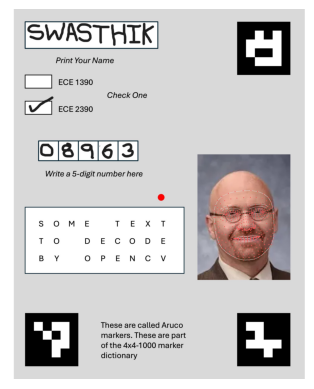

In [42]:

mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils

image_rgb = cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB)

with mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
    results = face_mesh.process(image_rgb)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            mp_drawing.draw_landmarks(aligned_image, face_landmarks, mp_face_mesh.FACEMESH_CONTOURS)

image_rgb = cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.axis('off')
plt.show()
